In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [23]:
# Load and preprocess the data
mutated_df = pd.read_csv('tcga_mutated_protein_embeddings.csv')
wildtype_df = pd.read_csv('tcga_wildtype_protein_embeddings.csv')
clinical_df = pd.read_csv("hf://datasets/seq-to-pheno/TCGA-Cancer-Variant-and-Clinical-Data/protein_sequences_metadata.tsv", sep="\t")

In [24]:
def preprocess_embeddings(df):
    # Convert Embedding column to individual features (from strings to arrays)
    df['Embedding'] = df['Embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=',') if isinstance(x, str) else x)
    
    # Replace 'unknown' values in relevant columns with NaN
    df['Cancer Type'] = df['Cancer Type'].replace('unknown', np.nan)
    df['Cancer Stage'] = df['Cancer Stage'].replace('unknown', np.nan)
    
    # Ensure 'Donor Survival Time' is numeric
    df['Donor Survival Time'] = pd.to_numeric(df['Donor Survival Time'], errors='coerce')
    
    # Remove rows with NaN values in the Embedding column and other relevant columns
    df = df.dropna(subset=['Embedding', 'Cancer Type', 'Cancer Stage', 'Donor Survival Time'])
    
    # Extract embedding values as a feature matrix
    embeddings = np.vstack(df['Embedding'].values)
    
    # Standardize the embeddings (mean=0, variance=1)
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)
    
    # Add scaled embeddings as separate columns
    embeddings_df = pd.DataFrame(embeddings_scaled, index=df.index)
    embeddings_df.columns = embeddings_df.columns.astype(str)
    
    # Add relevant columns from clinical data to this embeddings dataframe
    embeddings_df['Donor Survival Time'] = df['Donor Survival Time']
    embeddings_df['Cancer Type'] = df['Cancer Type']
    embeddings_df['Cancer Stage'] = df['Cancer Stage']
    
    return embeddings_df

In [25]:
# Define a function to plot actual vs predicted values
def plot_results(y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolor='k', label='Predicted')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal fit')
    plt.title(title)
    plt.xlabel("Actual Donor Survival Time")
    plt.ylabel("Predicted Donor Survival Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define a function to plot residuals
def plot_residuals(y_test, y_pred, title):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, color='purple', alpha=0.6, edgecolor='k')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'Residuals Plot - {title}')
    plt.xlabel("Predicted Donor Survival Time")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Unique values in 'Cancer Stage' column:
['2' 'T3N0MX' '4' 'T3N1MX' 'IV' '3' 'T3aNXMX' 'III' 'T1bN0MX' '2a' '1'
 'T3N1bMX' 'T3aN0MX' 'T2N1bMX' '3b' 'T3bNXMX' 'T4N1M1' 'T1bN0M0' 'T1aN0M0'
 'T3NXMX' 'A' 'T3aN0M0' 'C' 'B' '3c' 'T2N1M1' 'T1aNXMX' 'T2N0MX' 'T1N0MX'
 'T1N1bMX' 'T1bNXMX' '1a' 'T1bN0M1' 'T3N1M0' 'T4N1bM1' 'T2N1MX' 'T2aNXMX'
 'T3N1M1' 'T3N1aMX']

Analyzing Cancer Type: Liver Cancer - RIKEN, JP
Mutated Protein Model - MSE: 124458.8292, R2: 0.3435
Wildtype Protein Model - MSE: 125317.8076, R2: 0.2882


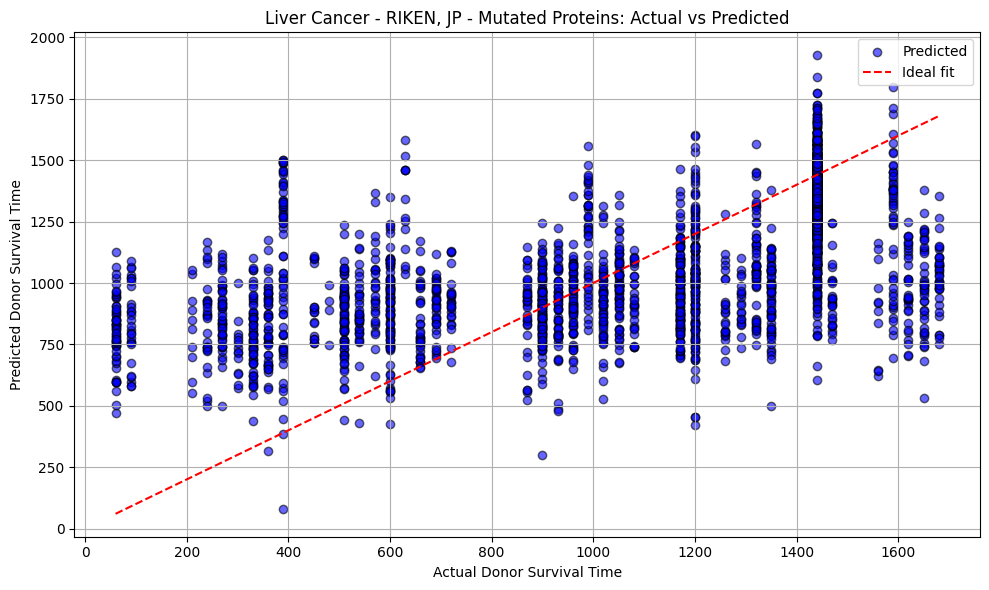

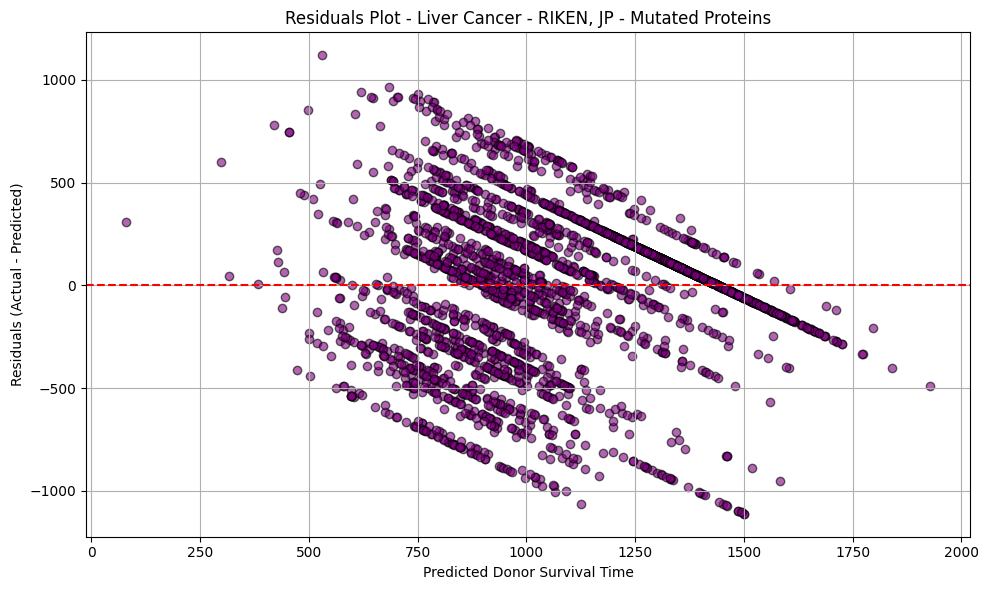

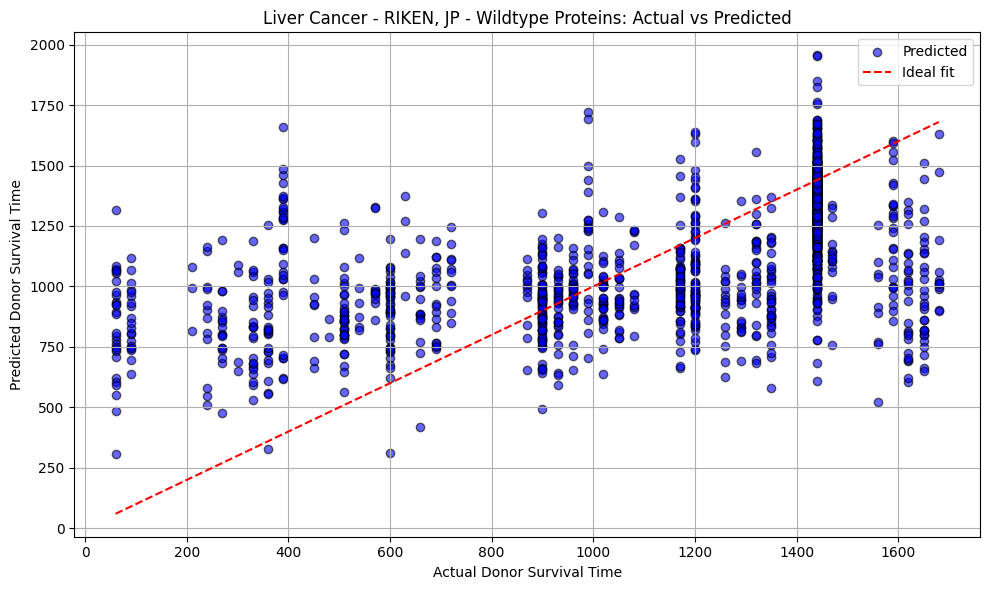

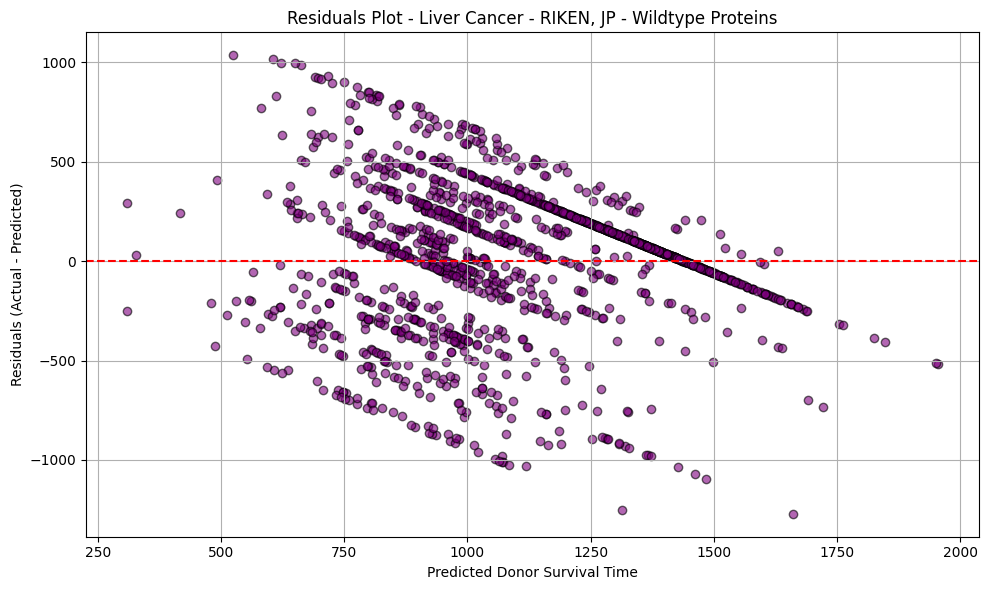


Analyzing Cancer Type: Pancreatic Cancer - AU
Mutated Protein Model - MSE: 124154.2713, R2: 0.3754
Wildtype Protein Model - MSE: 142064.4231, R2: 0.2493


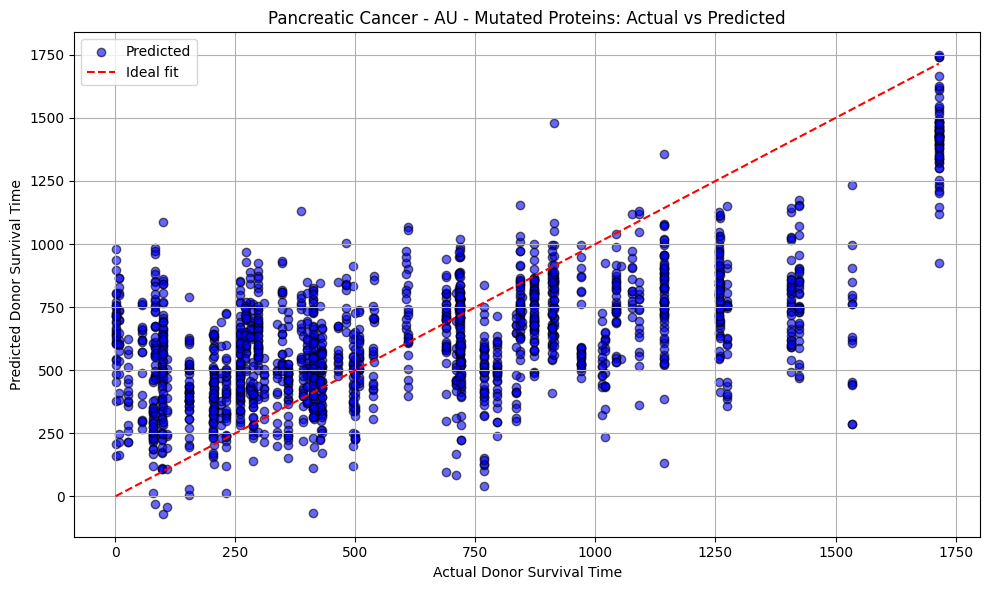

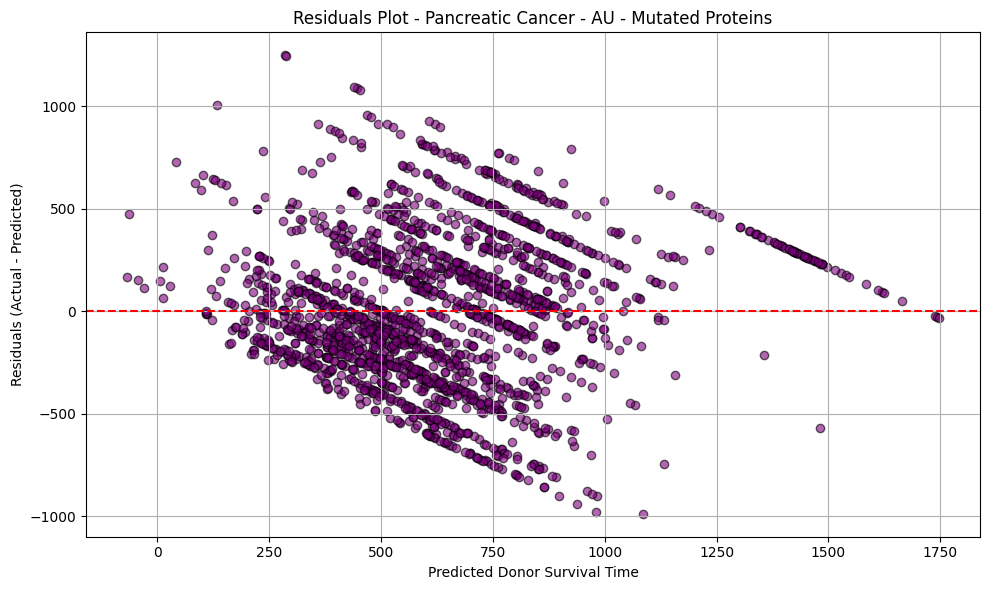

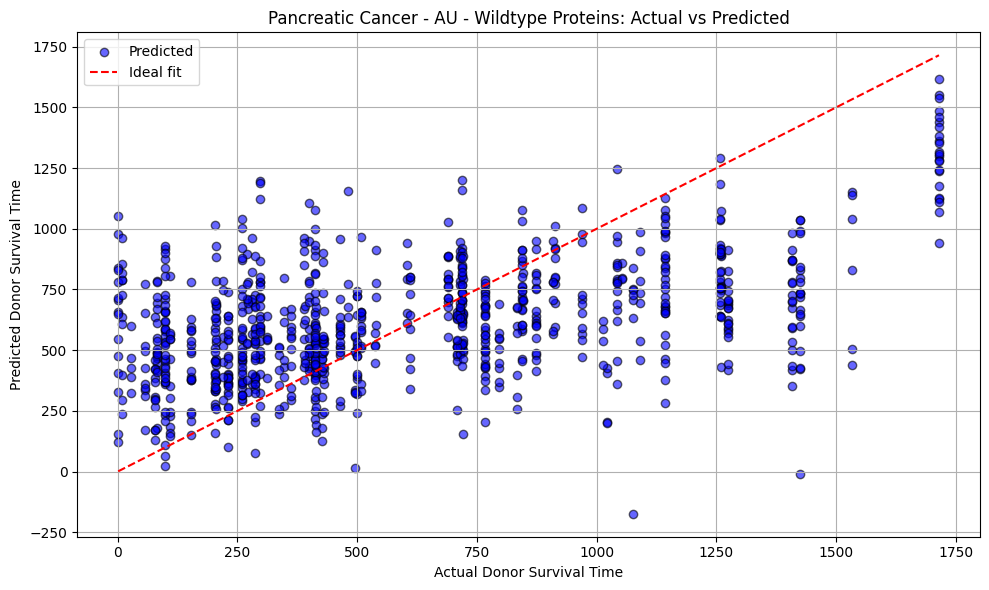

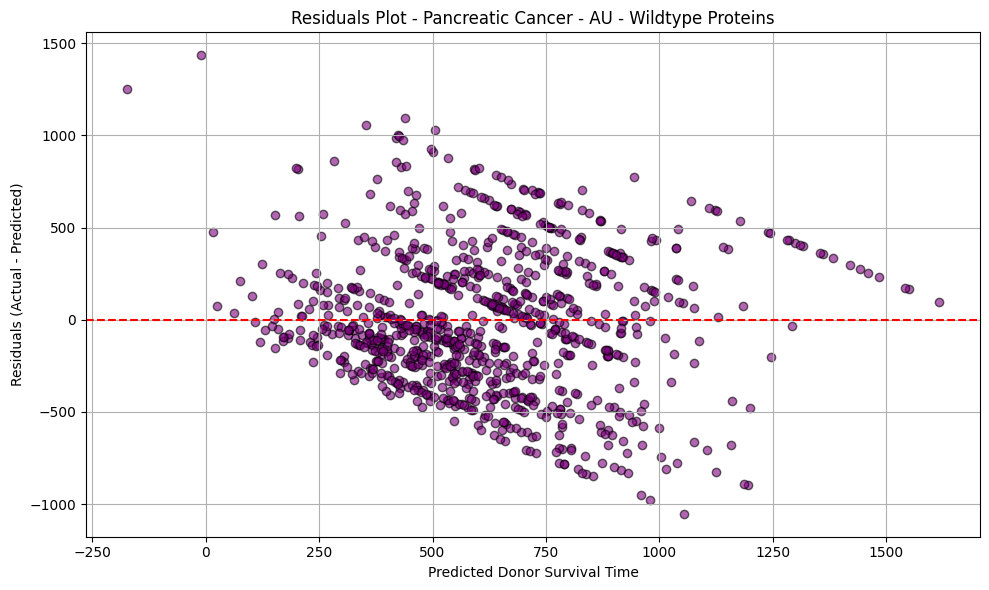


Analyzing Cancer Type: Ovarian Cancer - AU
Mutated Protein Model - MSE: 168017.7560, R2: 0.1923
Wildtype Protein Model - MSE: 191068.8141, R2: 0.1587


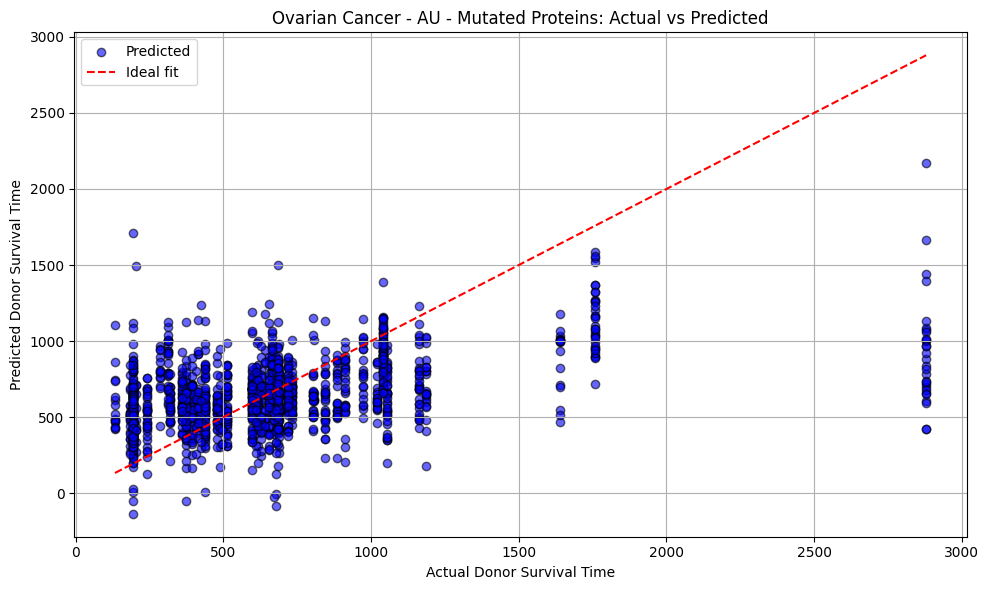

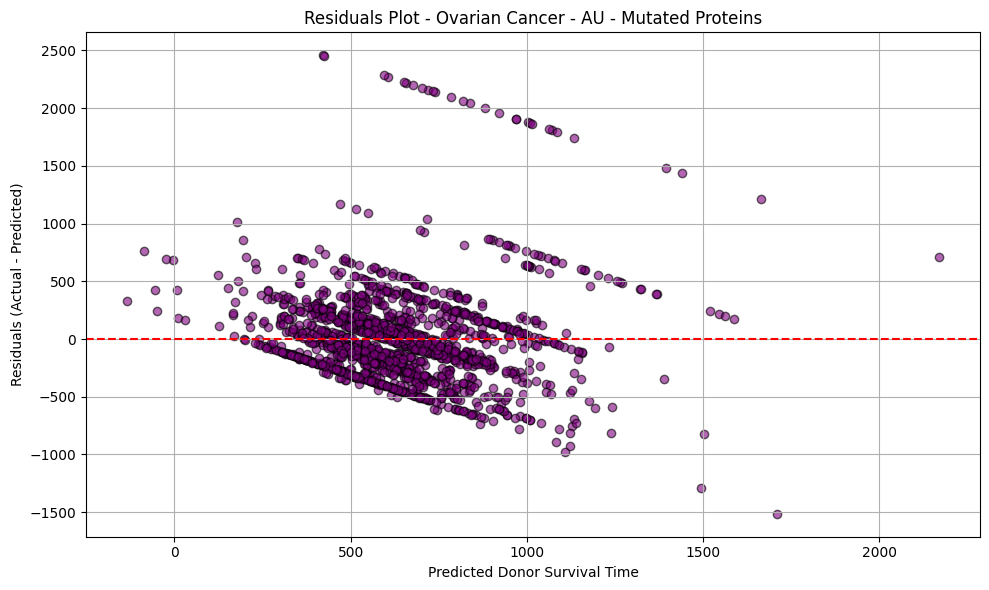

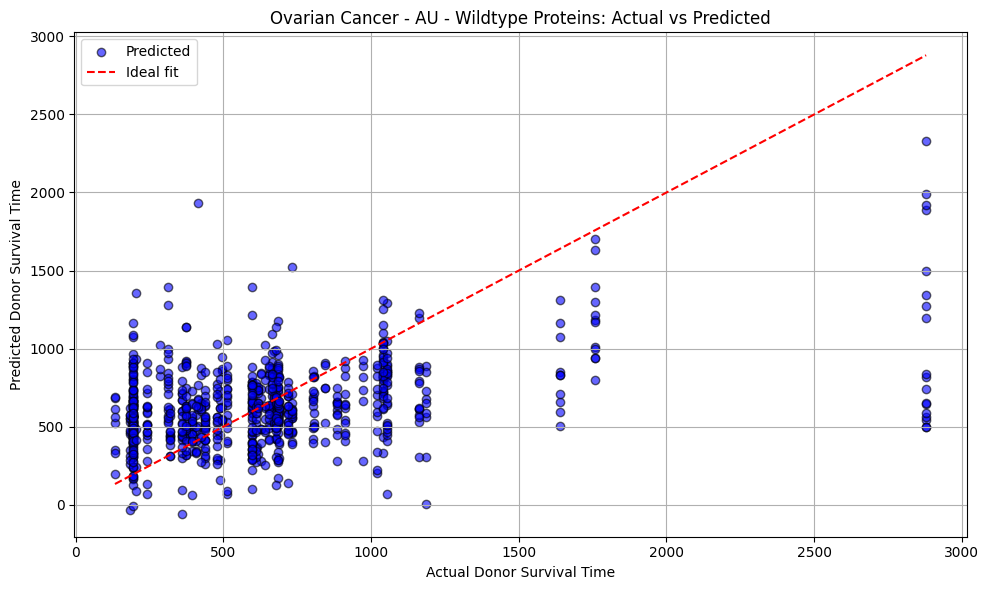

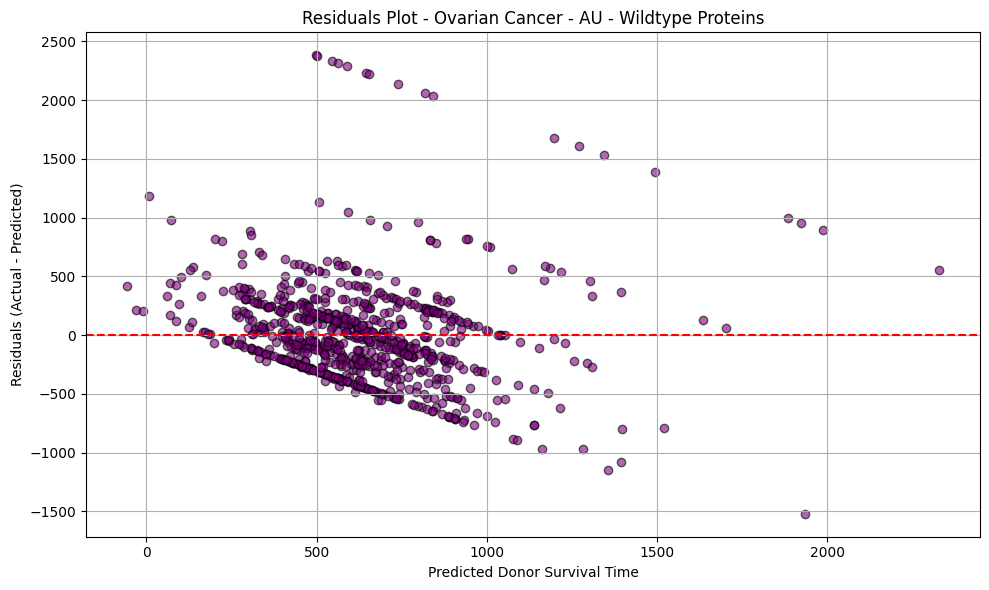


Analyzing Cancer Type: Renal Cell Cancer - EU
Mutated Protein Model - MSE: 175794.0410, R2: 0.4756
Wildtype Protein Model - MSE: 176237.2513, R2: 0.4635


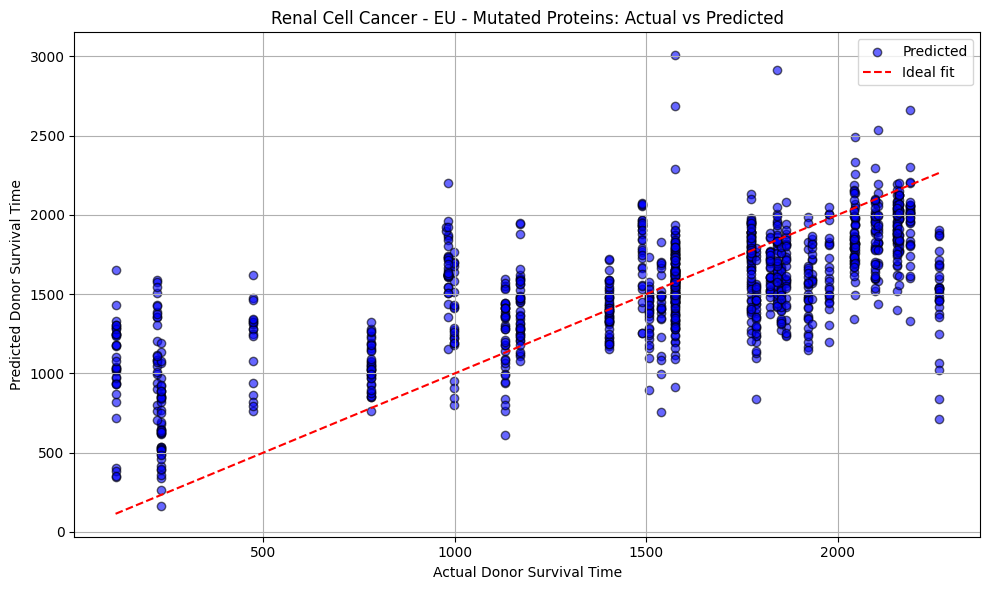

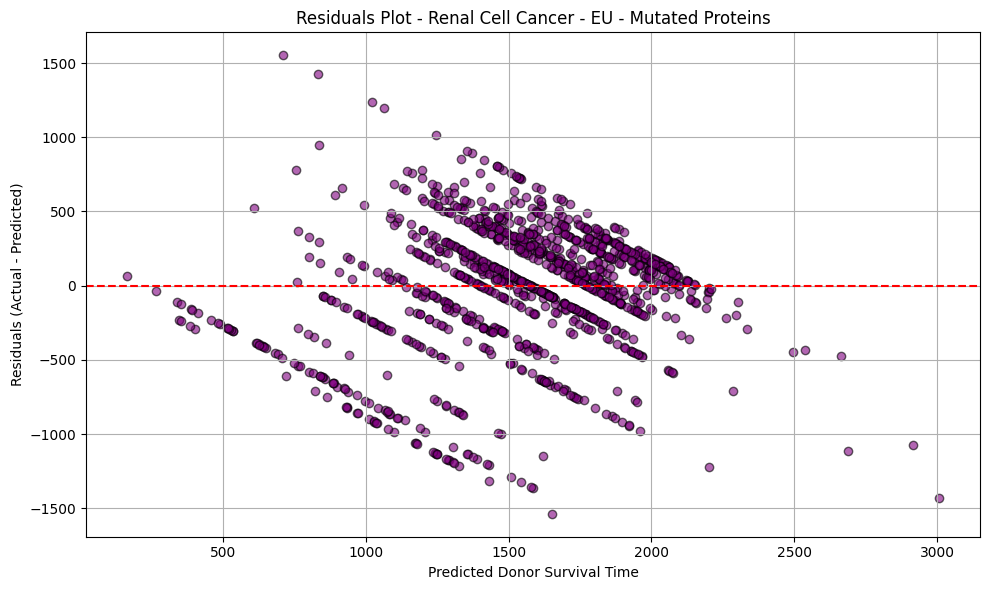

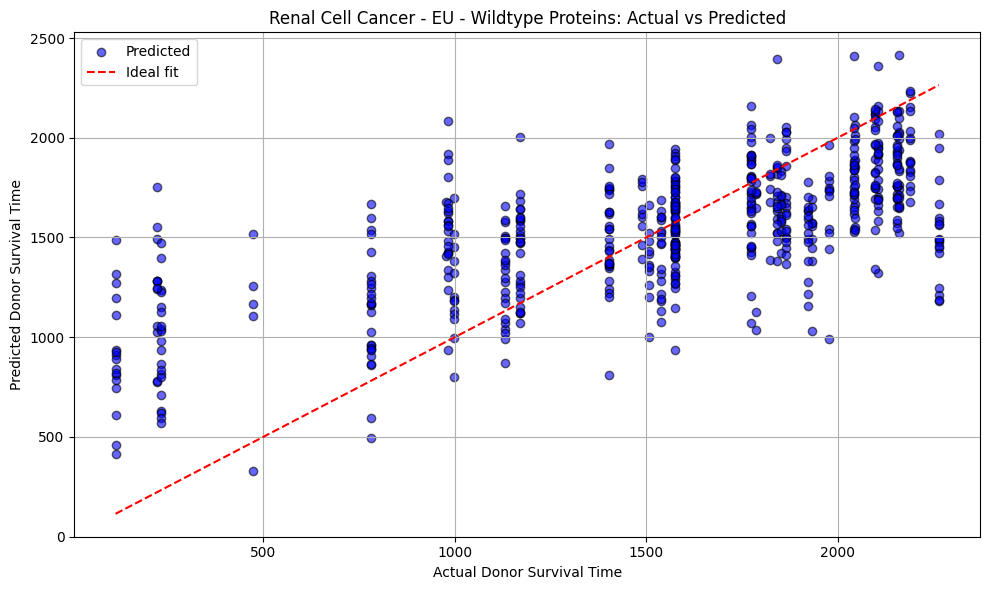

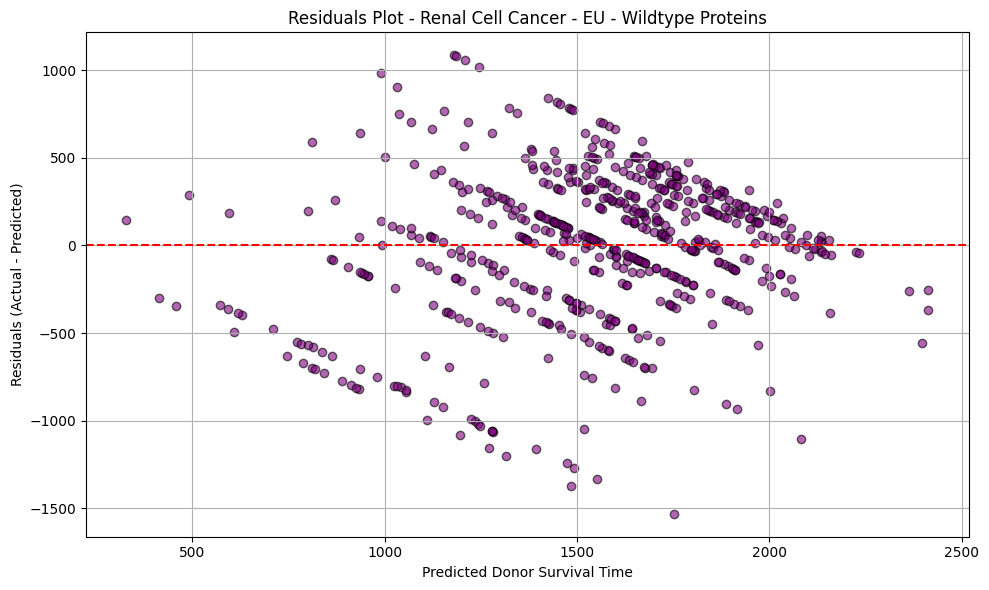


Analyzing Cancer Type: Esophageal Adenocarcinoma - UK
Mutated Protein Model - MSE: 5006.2527, R2: 0.7948
Wildtype Protein Model - MSE: 7407.8558, R2: 0.6787


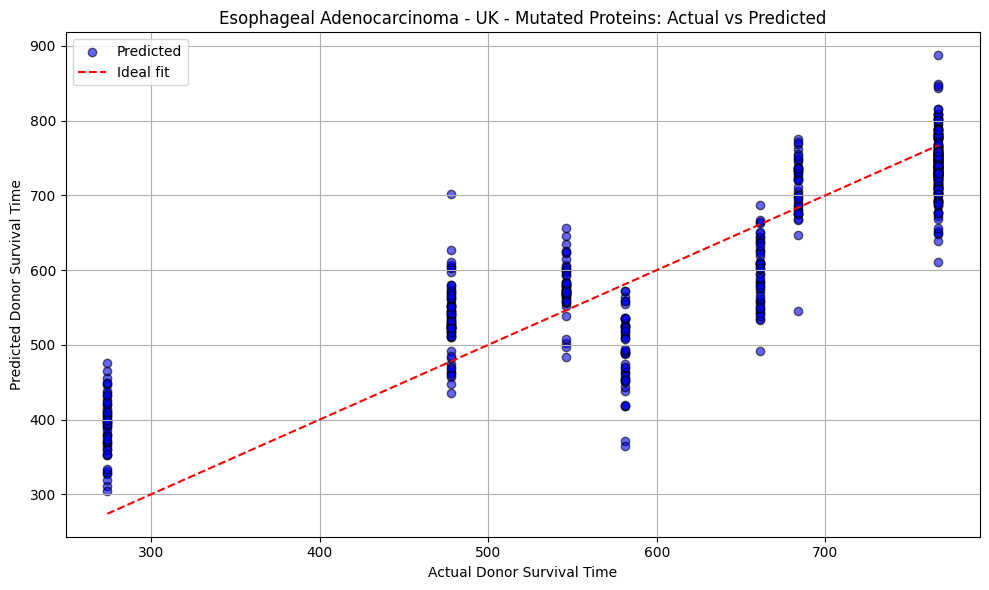

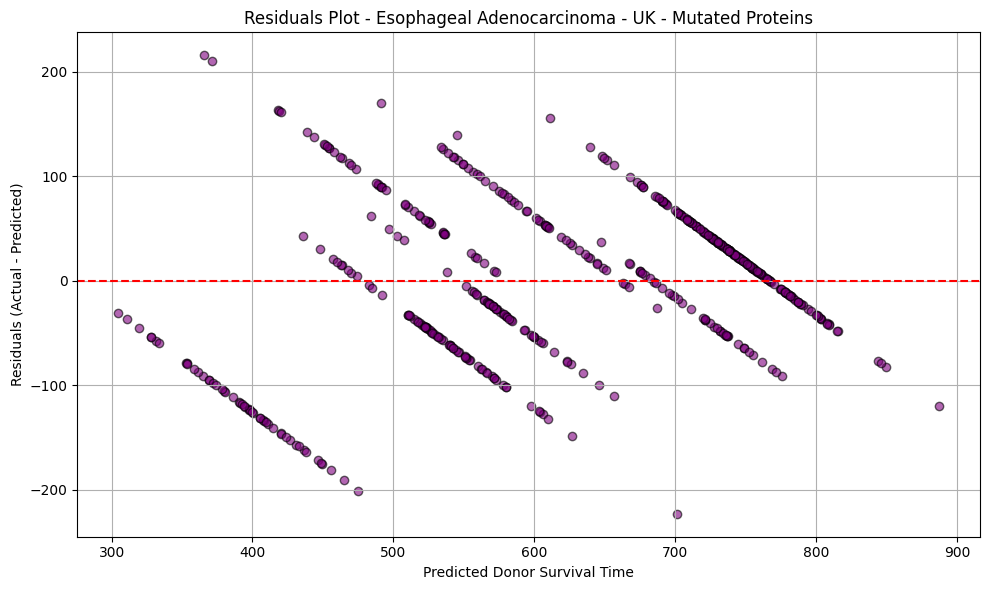

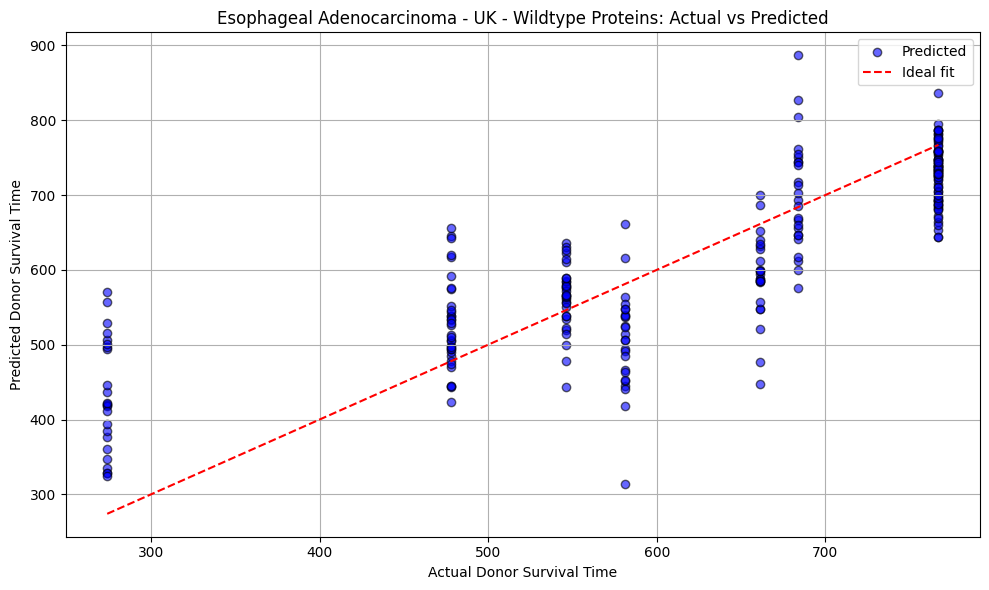

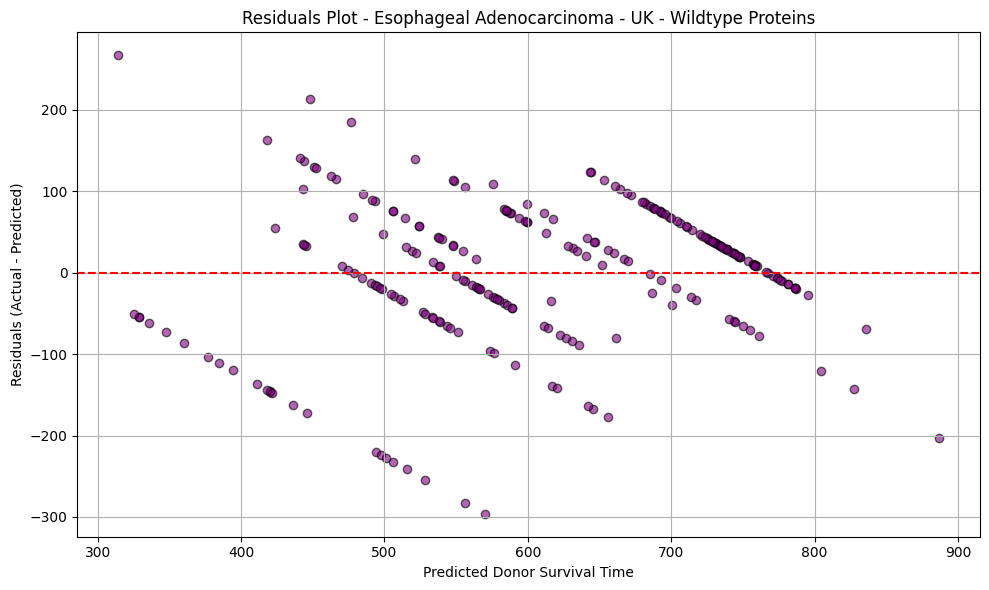


Analyzing Cancer Type: Chronic Lymphocytic Leukemia - ES
Mutated Protein Model - MSE: 2676311.6826, R2: 0.1890
Wildtype Protein Model - MSE: 2521608.5802, R2: 0.3882


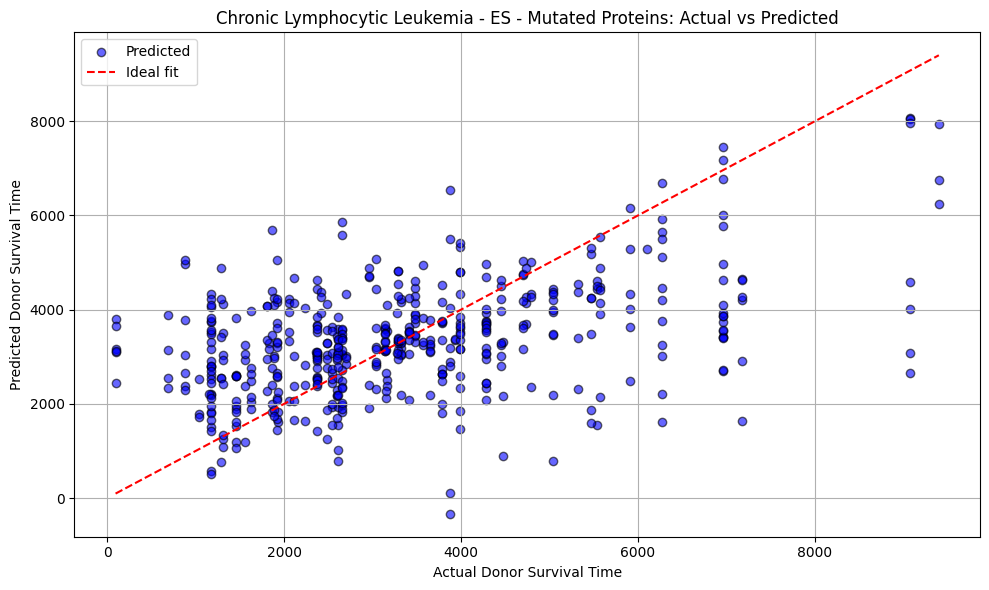

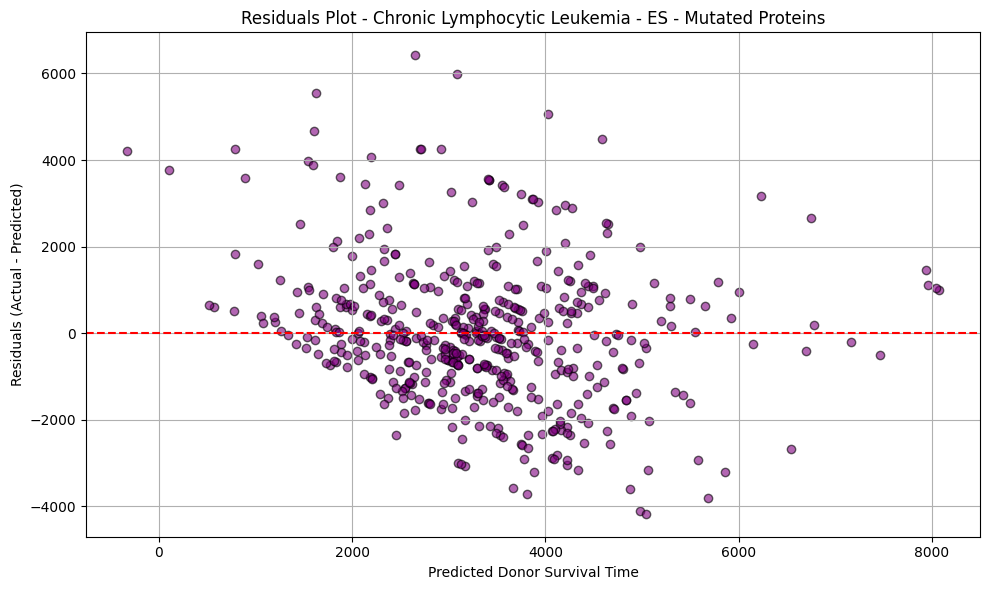

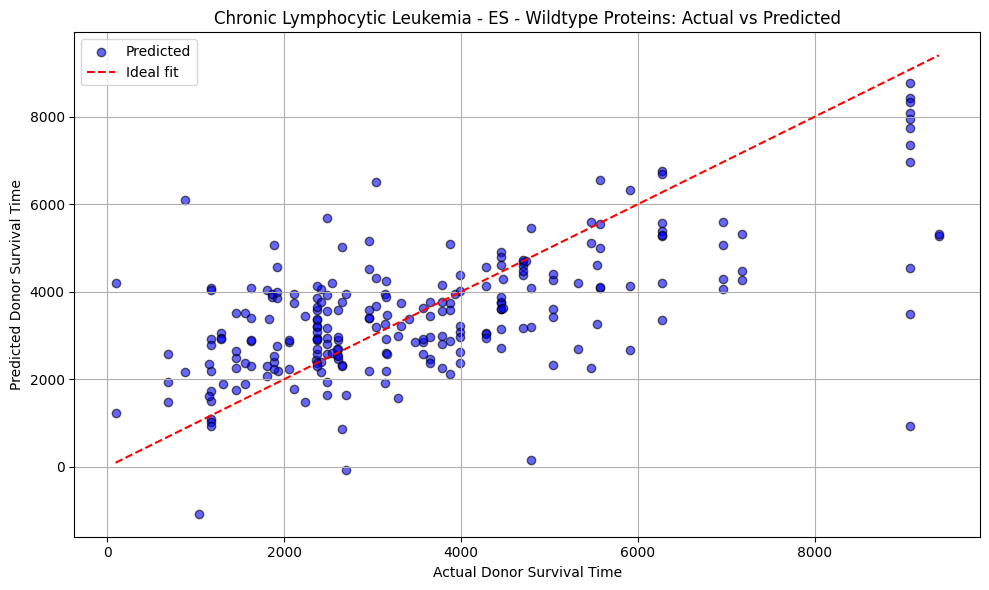

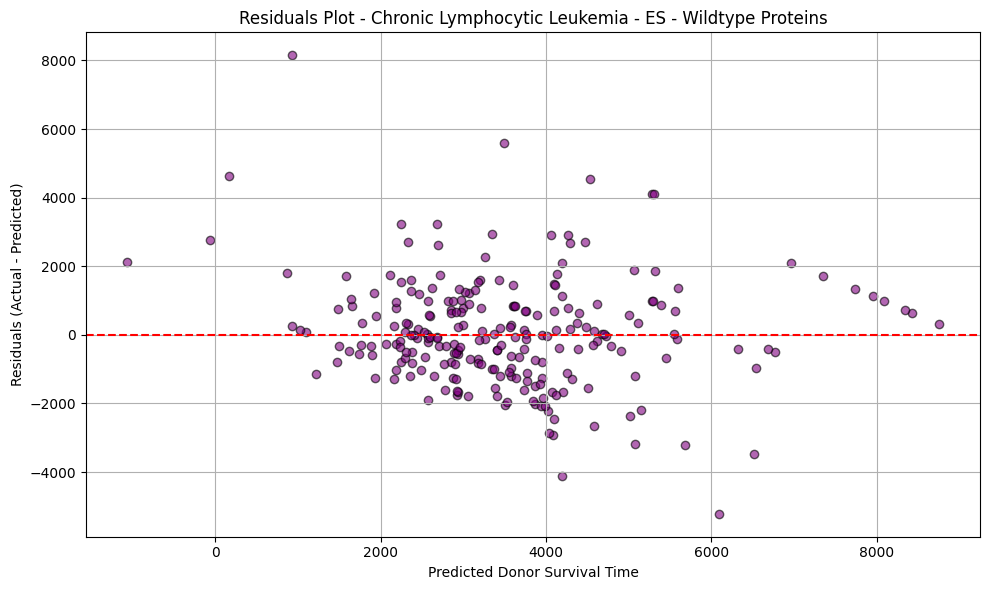

In [26]:
merged_mutated = pd.merge(mutated_df, clinical_df, how='inner', on=['transcript_id', 'wgs_aliquot_id'])
merged_wildtype = pd.merge(wildtype_df, clinical_df, how='inner', on=['transcript_id', 'wgs_aliquot_id'])

# Preprocess the data
mutated_embeddings = preprocess_embeddings(merged_mutated)
wildtype_embeddings = preprocess_embeddings(merged_wildtype)

# Print some diagnostic information
print("Unique values in 'Cancer Stage' column:")
print(mutated_embeddings['Cancer Stage'].unique())

# Analyze each cancer type
cancer_types = mutated_embeddings['Cancer Type'].unique()
for cancer in cancer_types:
    print(f"\nAnalyzing Cancer Type: {cancer}")
    
    # Filter the dataset for this cancer type
    cancer_mutated = mutated_embeddings[mutated_embeddings['Cancer Type'] == cancer]
    cancer_wildtype = wildtype_embeddings[wildtype_embeddings['Cancer Type'] == cancer]

    # Prepare feature matrix (X) and target variable (y)
    X_mutated = cancer_mutated.drop(['Donor Survival Time', 'Cancer Type'], axis=1)
    y_mutated = cancer_mutated['Donor Survival Time']
    
    X_wildtype = cancer_wildtype.drop(['Donor Survival Time', 'Cancer Type'], axis=1)
    y_wildtype = cancer_wildtype['Donor Survival Time']
    
    # Create a ColumnTransformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X_mutated.columns.drop('Cancer Stage')),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Cancer Stage'])
        ])

    # Create a pipeline with the preprocessor and the Ridge model
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=80))
    ])

    # Split the data and fit the model for mutated proteins
    X_train_mut, X_test_mut, y_train_mut, y_test_mut = train_test_split(X_mutated, y_mutated, test_size=0.2, random_state=42)
    model.fit(X_train_mut, y_train_mut)
    y_pred_mut = model.predict(X_test_mut)
    
    # Evaluate the mutated protein model
    mse_mut = mean_squared_error(y_test_mut, y_pred_mut)
    r2_mut = r2_score(y_test_mut, y_pred_mut)

    
    # Split the data and fit the model for wildtype proteins
    X_train_wild, X_test_wild, y_train_wild, y_test_wild = train_test_split(X_wildtype, y_wildtype, test_size=0.2, random_state=42)
    model.fit(X_train_wild, y_train_wild)
    y_pred_wild = model.predict(X_test_wild)
    
    # Evaluate the wildtype protein model
    mse_wild = mean_squared_error(y_test_wild, y_pred_wild)
    r2_wild = r2_score(y_test_wild, y_pred_wild)
    
    print(f"Mutated Protein Model - MSE: {mse_mut:.4f}, R2: {r2_mut:.4f}")
    print(f"Wildtype Protein Model - MSE: {mse_wild:.4f}, R2: {r2_wild:.4f}")


    # Generate plots for mutated proteins
    plot_results(y_test_mut, y_pred_mut, f"{cancer} - Mutated Proteins: Actual vs Predicted")
    plot_residuals(y_test_mut, y_pred_mut, f"{cancer} - Mutated Proteins")

    # Generate plots for wildtype proteins
    plot_results(y_test_wild, y_pred_wild, f"{cancer} - Wildtype Proteins: Actual vs Predicted")
    plot_residuals(y_test_wild, y_pred_wild, f"{cancer} - Wildtype Proteins")

